In [1]:
import os
import sv as SV
import numpy as np 
import astropy.table as atable
from tqdm.notebook import tqdm, trange

In [2]:
from desitarget import cuts as desi_cuts

In [3]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
!pip install corner --user
import corner as DFM

In [5]:
ls_S_dir = '/global/cfs/cdirs/cosmo/data/legacysurvey/dr9/south/sweep/9.0'
ls_N_dir = '/global/cfs/cdirs/cosmo/data/legacysurvey/dr9/north/sweep/9.0'

cat_S = atable.Table.read(os.path.join(ls_S_dir, 'sweep-200p005-210p010.fits'))
cat_N = atable.Table.read(os.path.join(ls_N_dir, 'sweep-190p040-200p045.fits'))

In [6]:
cat_S['PHOTSYS'] = 'S'
cat_N['PHOTSYS'] = 'N'

In [7]:
def BGS_quality_mask(targets, south=True):
    ''' apply BGS quality cut and imaging mask
    '''
    photsys_north, photsys_south, obs_rflux, gflux, rflux, zflux,                 \
    w1flux, w2flux, gfiberflux, rfiberflux, zfiberflux,                           \
    gfibertotflux, rfibertotflux, zfibertotflux,                                  \
    objtype, release, ra, dec, gfluxivar, rfluxivar, zfluxivar, w1fluxivar,       \
    gnobs, rnobs, znobs, gfracflux, rfracflux, zfracflux,                         \
    gfracmasked, rfracmasked, zfracmasked,                                        \
    gfracin, rfracin, zfracin, gallmask, rallmask, zallmask,                      \
    gsnr, rsnr, zsnr, w1snr, w2snr, dchisq, deltaChi2, maskbits, refcat = desi_cuts._prepare_optical_wise(objects=targets, mask=True)

    gaia, pmra, pmdec, parallax, parallaxovererror, parallaxerr, gaiagmag, \
    gaiabmag, gaiarmag, gaiaaen, gaiadupsource, Grr, gaiaparamssolved, \
    gaiabprpfactor, gaiasigma5dmax, galb = desi_cuts._prepare_gaia(objects=targets, colnames=None)

    bgs = np.ones_like(gnobs, dtype='?')    
    bgs &= (gnobs >= 1) & (rnobs >= 1) & (znobs >= 1)
    bgs &= (gfluxivar > 0) & (rfluxivar > 0) & (zfluxivar > 0)
    
    # ADM geometric masking cuts from the Legacy Surveys.
    # BRIGHT & CLUSTER for BGS
    bgs &= desi_cuts.imaging_mask(maskbits, bgsmask=True)

    return bgs

In [8]:
qm_S = BGS_quality_mask(cat_S, south=True)
qm_N = BGS_quality_mask(cat_N, south=True)

In [9]:
optw_S = desi_cuts._prepare_optical_wise(objects=cat_S, mask=True)
optw_N = desi_cuts._prepare_optical_wise(objects=cat_N, mask=True)

gaia_S = desi_cuts._prepare_gaia(objects=cat_S, colnames=None)
gaia_N = desi_cuts._prepare_gaia(objects=cat_N, colnames=None)

In [10]:
rfib_S = 22.5 - 2.5 * np.log10(optw_S[9].clip(1e-16))
gmag_S = 22.5 - 2.5 * np.log10(optw_S[3].clip(1e-16))
rmag_S = 22.5 - 2.5 * np.log10(optw_S[4].clip(1e-16))
zmag_S = 22.5 - 2.5 * np.log10(optw_S[5].clip(1e-16))
w1_S = 22.5 - 2.5 * np.log10(optw_S[6].clip(1e-16))

gaia_g_S = gaia_S[6]
G_rr_S = gaia_S[11]

rfib_N = 22.5 - 2.5 * np.log10(optw_N[9].clip(1e-16))
gmag_N = 22.5 - 2.5 * np.log10(optw_N[3].clip(1e-16))
rmag_N = 22.5 - 2.5 * np.log10(optw_N[4].clip(1e-16))
zmag_N = 22.5 - 2.5 * np.log10(optw_N[5].clip(1e-16))
w1_N = 22.5 - 2.5 * np.log10(optw_N[6].clip(1e-16))

gaia_g_N = gaia_N[6]
G_rr_N = gaia_N[11]

In [22]:
def BGS_sample(targets, south=True, targtype='bright'):
    ''' apply BGS quality cut and imaging mask
    '''
    photsys_north, photsys_south, obs_rflux, gflux, rflux, zflux,                 \
    w1flux, w2flux, gfiberflux, rfiberflux, zfiberflux,                           \
    gfibertotflux, rfibertotflux, zfibertotflux,                                  \
    objtype, release, ra, dec, gfluxivar, rfluxivar, zfluxivar, w1fluxivar,       \
    gnobs, rnobs, znobs, gfracflux, rfracflux, zfracflux,                         \
    gfracmasked, rfracmasked, zfracmasked,                                        \
    gfracin, rfracin, zfracin, gallmask, rallmask, zallmask,                      \
    gsnr, rsnr, zsnr, w1snr, w2snr, dchisq, deltaChi2, maskbits, refcat = desi_cuts._prepare_optical_wise(objects=targets, mask=True)

    gaia, pmra, pmdec, parallax, parallaxovererror, parallaxerr, gaiagmag, \
    gaiabmag, gaiarmag, gaiaaen, gaiadupsource, Grr, gaiaparamssolved, \
    gaiabprpfactor, gaiasigma5dmax, galb = desi_cuts._prepare_gaia(objects=targets, colnames=None)
    
    bgs = desi_cuts.isBGS(
            gflux=gflux, rflux=rflux, zflux=zflux, w1flux=w1flux, w2flux=w2flux, rfibertotflux=rfibertotflux,
            rfiberflux=rfiberflux, gnobs=gnobs, rnobs=rnobs, znobs=znobs,
            gfluxivar=gfluxivar, rfluxivar=rfluxivar, zfluxivar=zfluxivar,
            maskbits=maskbits, Grr=Grr, refcat=np.array(refcat).astype(str), w1snr=w1snr, w2snr=w2snr, gaiagmag=gaiagmag,
            objtype=objtype, primary=None, south=south, targtype=targtype)
    return bgs

In [23]:
bgs_bright_S = BGS_sample(cat_S, south=True, targtype='bright')
bgs_bright_N = BGS_sample(cat_N, south=False, targtype='bright')

In [24]:
bgs_faint_S = BGS_sample(cat_S, south=True, targtype='faint')
bgs_faint_N = BGS_sample(cat_N, south=False, targtype='faint')

In [25]:
is_galaxy_S = (G_rr_S > 0.6) | (gaia_g_S == 0)
is_galaxy_N = (G_rr_N > 0.6) | (gaia_g_N == 0)
print(np.mean(is_galaxy_S), np.mean(is_galaxy_N))

0.9590894083210405 0.9588036084045856


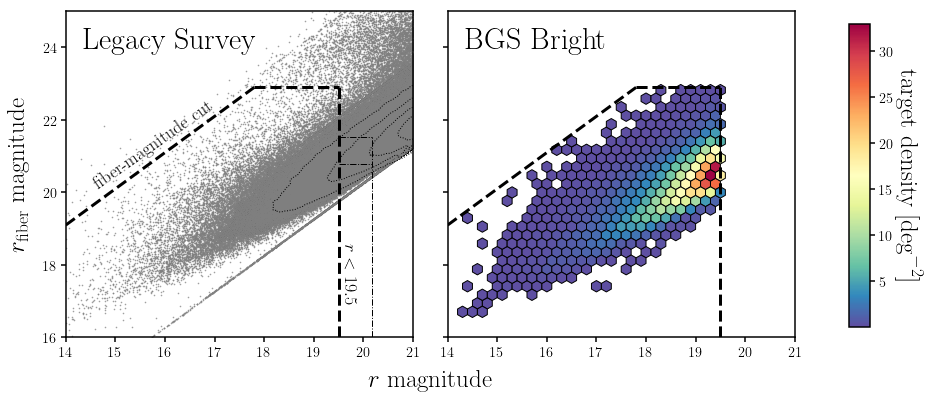

In [35]:
fig = plt.figure(figsize=(15,6))
sub = fig.add_subplot(121)

DFM.hist2d(np.concatenate([rmag_S[is_galaxy_S], rmag_N[is_galaxy_N]]), 
           np.concatenate([rfib_S[is_galaxy_S], rfib_N[is_galaxy_N]]), 
           range=[(14, 21), (16, 25)], color='k', 
           plot_density=False, plot_datapoints=True, no_fill_contours=True, 
           bins=200, smooth=True, 
           contour_kwargs={'linewidths': 1, 'linestyles': ':'}, 
           ax=sub)
sub.scatter(rmag_S[is_galaxy_S], rfib_S[is_galaxy_S], c='gray', s=0.1, rasterized=True)
sub.scatter(rmag_N[is_galaxy_N], rfib_N[is_galaxy_N], c='gray', s=0.1, rasterized=True)
sub.text(0.05, 0.95, r'Legacy Survey', ha='left', va='top', transform=sub.transAxes, fontsize=30)


sub.text(14.5, 20.1, 'fiber-magnitude cut', rotation=35, fontsize=18)
sub.plot([14, 17.8], [19.1, 22.9], c='k', ls='--', lw=3)
sub.plot([17.8, 19.5], [22.9, 22.9], c='k', ls='--', lw=3)

sub.text(19.55, 17., '$r < 19.5$', rotation=270, fontsize=18)
sub.plot([19.5, 19.5], [16., 22.9], c='k', ls='--', lw=3)

sub.plot([19.5, 20.175], [20.79, 20.79], c='k', ls='-.', lw=1)
sub.plot([19.5, 20.175], [21.54, 21.54], c='k', ls='-.', lw=1)
sub.plot([20.175, 20.175], [16., 21.54], c='k', ls='-.', lw=1)

sub.set_xlim(14, 21)
sub.set_ylim(16, 25)
sub.set_yticks([16, 18, 20, 22, 24])

sub = fig.add_subplot(122)
hb = sub.hexbin(rmag_S[bgs_bright_S], rfib_S[bgs_bright_S], 
                C=np.ones(np.sum(bgs_bright_S))/47, 
                reduce_C_function=np.sum, extent=(14, 20, 16, 24), gridsize=30, 
                edgecolors='k', linewidth=1., mincnt=2, cmap='Spectral_r')
sub.text(0.05, 0.95, r'BGS Bright', ha='left', va='top', transform=sub.transAxes, fontsize=30)

sub.plot([14, 17.8], [19.1, 22.9], c='k', ls='--', lw=3)
sub.plot([17.8, 19.5], [22.9, 22.9], c='k', ls='--', lw=3)

sub.plot([19.5, 19.5], [16., 22.9], c='k', ls='--', lw=3)

sub.set_xlim(14, 21)
sub.set_ylim(16, 25)
sub.set_yticks([16, 18, 20, 22, 24])
sub.set_yticklabels([])

bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel(r'$r$ magnitude', labelpad=10, fontsize=25) 
bkgd.set_ylabel(r'$r_{\rm fiber}$ magnitude', labelpad=10, fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.subplots_adjust(wspace=0.1, right=0.8)

cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.ax.set_ylabel(r'target density [${\rm deg}^{-2}$]', labelpad=30, fontsize=25, rotation=270)
fig.savefig('figs/bgs_bright.pdf', bbox_inches='tight')

In [27]:
fibcol_S = (zmag_S - w1_S) - 3/2.5 * (gmag_S - rmag_S) + 1.2
fibcol_N = (zmag_N - w1_N) - 3/2.5 * (gmag_N - rmag_N) + 1.2

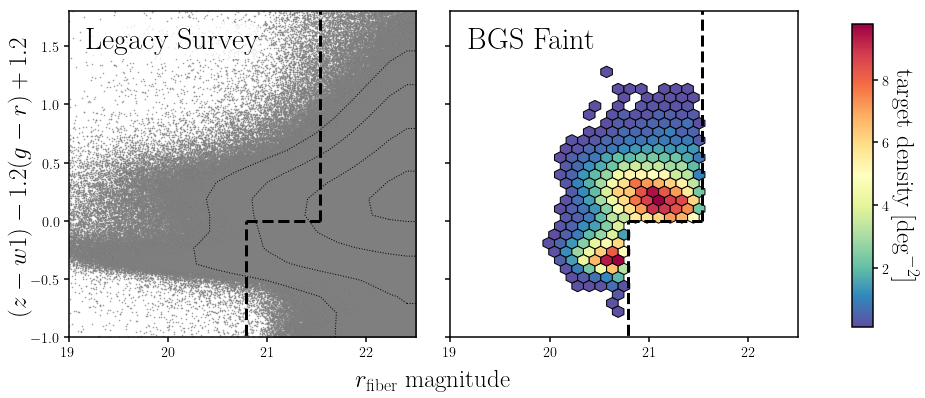

In [28]:
fig = plt.figure(figsize=(15,6))
sub = fig.add_subplot(121)

sub.scatter(rfib_S[is_galaxy_S], fibcol_S[is_galaxy_S], c='gray', s=0.1, rasterized=True)
sub.scatter(rfib_N[is_galaxy_N] - 0.04, fibcol_N[is_galaxy_N], c='gray', s=0.1, rasterized=True)
DFM.hist2d(np.concatenate([rfib_S[is_galaxy_S], rfib_N[is_galaxy_N] - 0.04]), 
           np.concatenate([fibcol_S[is_galaxy_S], fibcol_N[is_galaxy_N]]), 
           range=[(19.0, 22.5), (-1., 1.8)], color='k', 
           plot_density=False, plot_datapoints=True, no_fill_contours=True, 
           smooth=True, 
           contour_kwargs={'linewidths': 1, 'linestyles': ':'}, 
           ax=sub)
sub.scatter([], [], c='gray', s=100, label='Legacy Survey')

sub.plot([20.79, 20.79], [-2, 0.], c='k', ls='--', lw=3)
sub.plot([20.79, 21.54], [0., 0.], c='k', ls='--', lw=3)
sub.plot([21.54, 21.54], [0., 2.], c='k', ls='--', lw=3)

sub.text(0.05, 0.95, r'Legacy Survey', ha='left', va='top', transform=sub.transAxes, fontsize=30)
sub.fill_between([19.2, 20.9], [1.4, 1.4], [1.7, 1.7], color='white', alpha=0.75)

sub.set_yticks([-1., -0.5, 0., 0.5, 1., 1.5])
sub.set_ylim(-1., 1.8)
#sub.set_xlabel(r'$r_{\rm fiber}$ magnitude', fontsize=25)
sub.set_xlim(19.0, 22.5)
sub.set_xticks([19., 20, 21, 22])


sub = fig.add_subplot(122)

hb = sub.hexbin(rfib_S[bgs_faint_S], fibcol_S[bgs_faint_S], C=(np.ones(len(bgs_faint_S))/47).astype(float),
                reduce_C_function=np.sum, extent=(19., 22.5, -1., 1.5), gridsize=30, mincnt=5,
                cmap='Spectral_r', edgecolors='k', linewidth=1.)

sub.plot([20.79, 20.79], [-2, 0.], c='k', ls='--', lw=3)
sub.plot([20.79, 21.54], [0., 0.], c='k', ls='--', lw=3)
sub.plot([21.54, 21.54], [0., 2.], c='k', ls='--', lw=3)

#sub.fill_between([19.2, 20.5], [1.3, 1.3], [1.7, 1.7], color='white', alpha=0.75)
#sub.legend(loc='upper left', bbox_to_anchor=(-0.035, 1.025), fontsize=20, handletextpad=-0.4)
sub.text(0.05, 0.95, r'BGS Faint', ha='left', va='top', transform=sub.transAxes, fontsize=30)


sub.set_yticks([-1., -0.5, 0., 0.5, 1., 1.5])
sub.set_ylim(-1., 1.8)
sub.set_xlim(19.0, 22.5)
sub.set_xticks([19., 20, 21, 22])
sub.set_yticklabels([])

bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel(r'$r_{\rm fiber}$ magnitude', labelpad=10, fontsize=25) 
bkgd.set_ylabel(r'$(z - w1) - 1.2 (g - r) + 1.2$', labelpad=10, fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.subplots_adjust(wspace=0.1, right=0.8)

cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.ax.set_ylabel(r'target density [${\rm deg}^{-2}$]', labelpad=30, fontsize=25, rotation=270)
fig.savefig('figs/bgs_faint.pdf', bbox_inches='tight')

In [19]:
# load compiled zsuccess rates to file
dat_dir = '/global/cscratch1/sd/chahah/bgs-cmxsv/sv-paper/'
#dat_dir = '/Users/chahah/data/bgs_cmxsv/sv_paper/'

sv1_gals = atable.Table.read(os.path.join(dat_dir, 'sv1.bgs_exps.efftime160_200.zsuccess.v4.fits'))
sv3_gals = atable.Table.read(os.path.join(dat_dir, 'sv3.bgs_exps.efftime160_200.zsuccess.v4.fits'))
main_gals = atable.Table.read(os.path.join(dat_dir, 'main.bgs_exps.efftime160_200.zsuccess.v4.fits'))

In [20]:
from desiutil.dust import ext_odonnell

sv1_gals = sv1_gals[(sv1_gals['PHOTSYS'] != '') & (sv1_gals['PHOTSYS'] != 'G')]
sv3_gals = sv3_gals[sv3_gals['PHOTSYS'] != '']

from speclite import filters
decamwise = filters.load_filters('decam2014-g', 'decam2014-r','decam2014-z', 'wise2010-W1', 'wise2010-W2')
bassmzlswise = filters.load_filters('BASS-g', 'BASS-r', 'MzLS-z','wise2010-W1', 'wise2010-W2')

RV = 3.1

sv1_mw_trans = np.array([10**(-0.4 * sv1_gals['EBV'][i] * RV * ext_odonnell(bassmzlswise.effective_wavelengths.value, Rv=RV)) if sv1_gals['PHOTSYS'][i] == 'N'
                         else 10**(-0.4 * sv1_gals['EBV'][i] * RV * ext_odonnell(decamwise.effective_wavelengths.value, Rv=RV)) for i in range(len(sv1_gals['EBV']))])
sv3_mw_trans = np.array([10**(-0.4 * sv3_gals['EBV'][i] * RV * ext_odonnell(bassmzlswise.effective_wavelengths.value, Rv=RV)) if sv3_gals['PHOTSYS'][i] == 'N'
                         else 10**(-0.4 * sv3_gals['EBV'][i] * RV * ext_odonnell(decamwise.effective_wavelengths.value, Rv=RV)) for i in range(len(sv3_gals['EBV']))])

In [21]:
sv1_gmag = 22.5 - 2.5 * np.log10((sv1_gals['FLUX_G']/sv1_mw_trans[:,0]).clip(1e-16))
sv1_rmag = 22.5 - 2.5 * np.log10((sv1_gals['FLUX_R']/sv1_mw_trans[:,1]).clip(1e-16))
sv1_zmag = 22.5 - 2.5 * np.log10((sv1_gals['FLUX_Z']/sv1_mw_trans[:,2]).clip(1e-16))
sv1_rfib = 22.5 - 2.5 * np.log10((sv1_gals['FIBERFLUX_R']/sv1_mw_trans[:,1]).clip(1e-16))
sv1_w1   = 22.5 - 2.5 * np.log10((sv1_gals['FLUX_W1']/sv1_mw_trans[:,3]).clip(1e-16))
sv1_g_rr = sv1_gals['GAIA_PHOT_G_MEAN_MAG'] - 22.5 + 2.5*np.log10(sv1_gals['FLUX_R'])

sv3_gmag = 22.5 - 2.5 * np.log10((sv3_gals['FLUX_G']/sv3_mw_trans[:,0]).clip(1e-16))
sv3_rmag = 22.5 - 2.5 * np.log10((sv3_gals['FLUX_R']/sv3_mw_trans[:,1]).clip(1e-16))
sv3_zmag = 22.5 - 2.5 * np.log10((sv3_gals['FLUX_Z']/sv3_mw_trans[:,2]).clip(1e-16))
sv3_rfib = 22.5 - 2.5 * np.log10((sv3_gals['FIBERFLUX_R']/sv3_mw_trans[:,1]).clip(1e-16))
sv3_w1   = 22.5 - 2.5 * np.log10((sv3_gals['FLUX_W1']/sv3_mw_trans[:,3]).clip(1e-16))
sv3_g_rr = sv3_gals['GAIA_PHOT_G_MEAN_MAG'] - 22.5 + 2.5*np.log10(sv3_gals['FLUX_R'])

In [22]:
from desitarget.sv1.sv1_targetmask import bgs_mask as sv1_bgs_mask
from desitarget.sv3.sv3_targetmask import bgs_mask as sv3_bgs_mask

sv1_bgs = sv1_gals['SV1_BGS_TARGET'] != 0 
sv1_brgt = (sv1_gals['SV1_BGS_TARGET'] & sv1_bgs_mask['BGS_BRIGHT']) != 0 
sv1_lowq = (sv1_gals['SV1_BGS_TARGET'] & sv1_bgs_mask['BGS_LOWQ']) != 0 
sv1_fain = (sv1_gals['SV1_BGS_TARGET'] & sv1_bgs_mask['BGS_FAINT']) != 0
sv1_fain_ext = (sv1_gals['SV1_BGS_TARGET'] & sv1_bgs_mask['BGS_FAINT_EXT']) != 0
sv1_fibmag = (sv1_gals['SV1_BGS_TARGET'] & sv1_bgs_mask['BGS_FIBMAG']) != 0

sv3_bgs = sv3_gals['SV3_BGS_TARGET'] != 0 
sv3_brgt = (sv3_gals['SV3_BGS_TARGET'] & sv3_bgs_mask['BGS_BRIGHT']) != 0 
sv3_fain = (sv3_gals['SV3_BGS_TARGET'] & sv3_bgs_mask['BGS_FAINT']) != 0 

In [23]:
sv3_offset = np.zeros(len(sv3_gals['PHOTSYS']))
sv3_offset[sv3_gals['PHOTSYS'] == 'N'] = 0.04

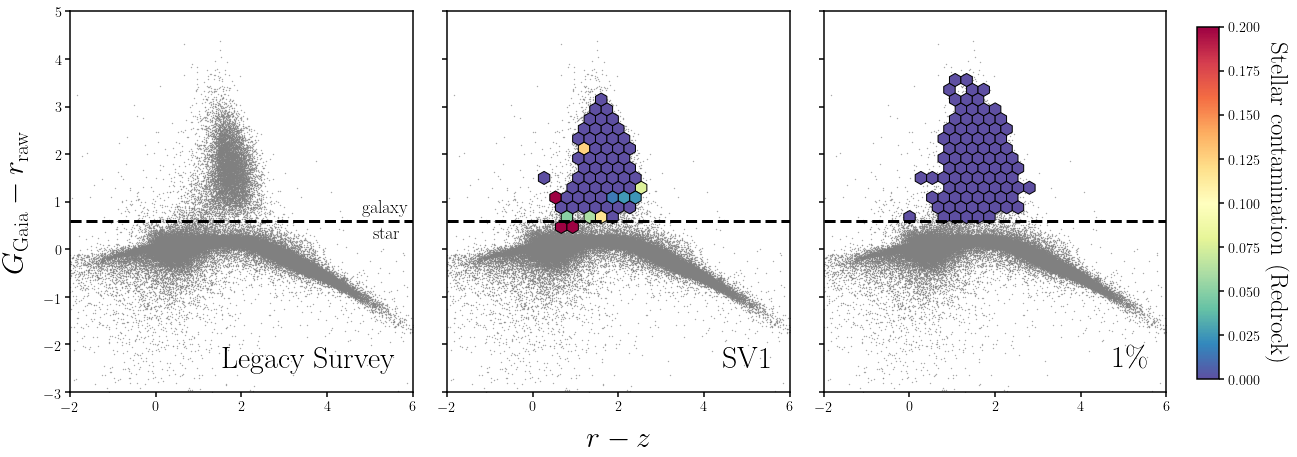

In [25]:
fig = plt.figure(figsize=(21,7))
sub = fig.add_subplot(131)

sub.scatter((gmag_S - zmag_S), G_rr_S, c='gray', s=0.1, rasterized=True)
sub.scatter((gmag_N - zmag_N), G_rr_N, c='gray', s=0.1, rasterized=True)
sub.scatter([], [], c='gray', s=100, label='LS')

sub.text(5.9, 0.69, 'galaxy', ha='right', va='bottom', fontsize=18)
sub.text(5.7, 0.5, 'star', ha='right', va='top', fontsize=18)
sub.axhline(0.6, color='k', linestyle='--', linewidth=3)

sub.text(0.95, 0.05, r'Legacy Survey', ha='right', va='bottom', transform=sub.transAxes, fontsize=30)

sub.set_xlim(-2., 6.)
sub.set_xticks([-2., 0., 2., 4., 6.])
sub.set_ylim(-3., 5.)

sub = fig.add_subplot(132)

sub.scatter((gmag_S - zmag_S), G_rr_S, c='gray', s=0.1, rasterized=True)
sub.scatter((gmag_N - zmag_N), G_rr_N, c='gray', s=0.1, rasterized=True)
sub.scatter([], [], c='gray', s=100, label='LS')
hb = sub.hexbin((sv1_gmag - sv1_zmag)[sv1_bgs], sv1_g_rr[sv1_bgs], 
                C=((sv1_gals['RR_SPECTYPE'] == 'STAR') | (sv1_gals['Z_TRUE'] < 0.00100069))[sv1_bgs].astype(float), 
                edgecolors='k', linewidth=1., reduce_C_function=np.mean, extent=(-2, 6, -2, 5), gridsize=30, vmin=0., vmax=0.2, mincnt=10, cmap='Spectral_r')#, alpha=0.75)

sub.axhline(0.6, color='k', linestyle='--', linewidth=3)

sub.text(0.95, 0.05, r'SV1', ha='right', va='bottom', transform=sub.transAxes, fontsize=30)

sub.set_xlim(-2., 6.)
sub.set_xticks([-2., 0., 2., 4., 6.])
sub.set_ylim(-3., 5.)
sub.set_yticklabels([])

sub = fig.add_subplot(133)
sub.scatter((gmag_S - zmag_S), G_rr_S, c='gray', s=0.1, rasterized=True)
sub.scatter((gmag_N - zmag_N), G_rr_N, c='gray', s=0.1, rasterized=True)
sub.scatter([], [], c='gray', s=100, label='Legacy Survey')

hb = sub.hexbin((sv3_gmag - sv3_zmag)[sv3_brgt | sv3_fain], sv3_g_rr[sv3_brgt | sv3_fain], 
                C=((sv3_gals['RR_SPECTYPE'] == 'STAR') & (sv3_gals['Z_TRUE'] < 0.00100069))[sv3_brgt | sv3_fain].astype(float), 
                edgecolors='k', linewidth=1., reduce_C_function=np.mean, extent=(-2, 6, -2, 5), gridsize=30, vmin=0., vmax=0.2, mincnt=10, cmap='Spectral_r')

#sub.scatter((sv3_gmag - sv3_rmag)[sv3_brgt | sv3_fain], sv3_g_rr[sv3_brgt | sv3_fain], c='r', s=1)

sub.axhline(0.6, color='k', linestyle='--', linewidth=3)

sub.text(0.95, 0.05, r'$1\%$', ha='right', va='bottom', transform=sub.transAxes, fontsize=30)

sub.set_xlim(-2., 6.)
sub.set_xticks([-2., 0., 2., 4., 6.])
sub.set_ylim(-3., 5.)
sub.set_yticklabels([])

bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel(r'$r - z$', labelpad=10, fontsize=30) 
bkgd.set_ylabel(r'$G_{\rm Gaia} - r_{\rm raw}$', labelpad=10, fontsize=30) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.subplots_adjust(wspace=0.1, right=0.85)

cbar_ax = fig.add_axes([0.87, 0.15, 0.015, 0.7])
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.ax.set_ylabel(r'Stellar contamination (Redrock)', labelpad=30, fontsize=25, rotation=270)
fig.savefig('figs/star_galaxy_redrock.pdf', bbox_inches='tight')

In [ ]:
star_galaxy_fail = sv1_bgs & (sv1_g_rr > 0.6) & ((sv1_gals['RR_SPECTYPE'] == 'STAR') | (sv1_gals['Z_TRUE'] < 0.00100069))
print(np.sum(star_galaxy_fail))

In [ ]:
for targ in ['BRIGHT', 'FAINT', 'FAINT_EXT', 'LOWQ', 'FIBMAG', 'BRIGHT_NORTH', 'BRIGHT_SOUTH', 'FAINT_NORTH', 'FAINT_SOUTH', 'FAINT_EXT_NORTH', 'FAINT_EXT_SOUTH']: 
    print(targ, np.sum(sv1_bgs & star_galaxy_fail & ((sv1_gals['SV1_BGS_TARGET'] & sv1_bgs_mask['BGS_%s' % targ]) != 0)))

In [ ]:
star_galaxy_fail_bright = sv1_bgs & star_galaxy_fail & sv1_brgt & ~sv1_lowq
print(np.sum(star_galaxy_fail_bright))

In [ ]:
sv1_gals[star_galaxy_fail_bright]

In [79]:
from astropy import units as u
from astropy.coordinates import SkyCoord

In [81]:
# galactic coordinates
c = SkyCoord(sv1_gals['TARGET_RA'] * u.degree, sv1_gals['TARGET_DEC'] * u.degree, frame='icrs')
sv1_gall = c.galactic.l.value
sv1_galb = c.galactic.b.value 

c = SkyCoord(sv3_gals['TARGET_RA'] * u.degree, sv3_gals['TARGET_DEC'] * u.degree, frame='icrs')
sv3_gall = c.galactic.l.value
sv3_galb = c.galactic.b.value 

In [99]:
sv1_near_gp = np.abs(sv1_galb) < 35
sv3_near_gp = np.abs(sv3_galb) < 35

Text(0, 0.5, 'stellar contamination (redrock)')

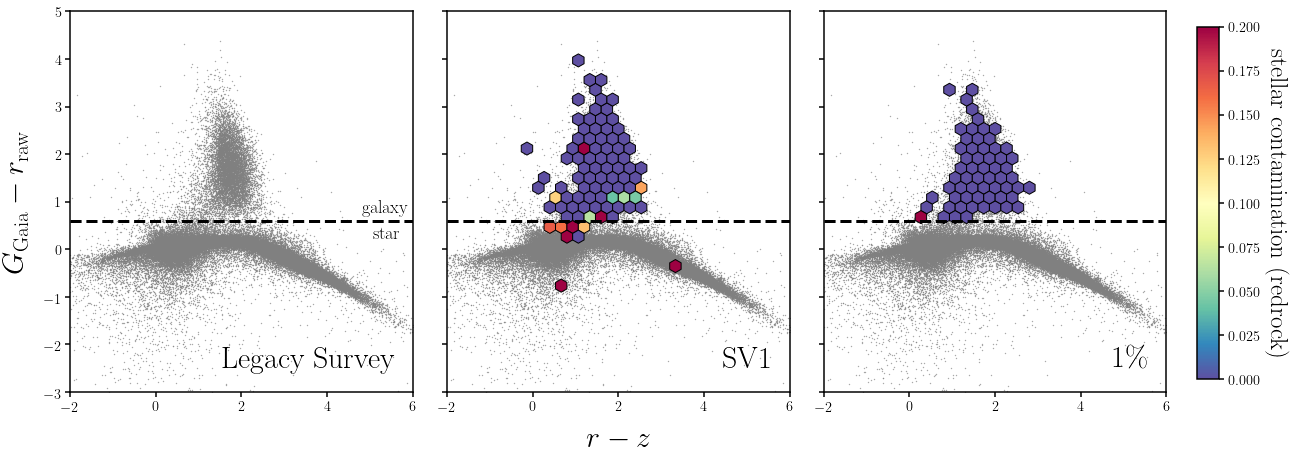

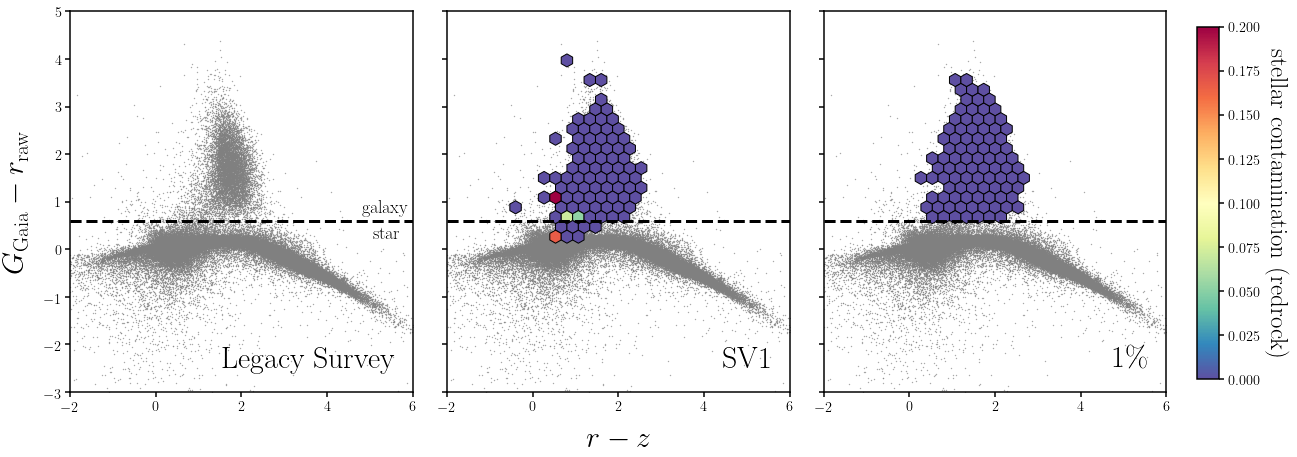

In [102]:
fig = plt.figure(figsize=(21,7))
sub = fig.add_subplot(131)

sub.scatter((gmag_S - zmag_S), G_rr_S, c='gray', s=0.1, rasterized=True)
sub.scatter((gmag_N - zmag_N), G_rr_N, c='gray', s=0.1, rasterized=True)
sub.scatter([], [], c='gray', s=100, label='LS')

sub.text(5.9, 0.69, 'galaxy', ha='right', va='bottom', fontsize=18)
sub.text(5.7, 0.5, 'star', ha='right', va='top', fontsize=18)
sub.axhline(0.6, color='k', linestyle='--', linewidth=3)

sub.text(0.95, 0.05, r'Legacy Survey', ha='right', va='bottom', transform=sub.transAxes, fontsize=30)

sub.set_xlim(-2., 6.)
sub.set_xticks([-2., 0., 2., 4., 6.])
sub.set_ylim(-3., 5.)

sub = fig.add_subplot(132)

sub.scatter((gmag_S - zmag_S), G_rr_S, c='gray', s=0.1, rasterized=True)
sub.scatter((gmag_N - zmag_N), G_rr_N, c='gray', s=0.1, rasterized=True)
sub.scatter([], [], c='gray', s=100, label='LS')
hb = sub.hexbin((sv1_gmag - sv1_zmag)[sv1_bgs & sv1_near_gp], sv1_g_rr[sv1_bgs & sv1_near_gp], 
                C=((sv1_gals['RR_SPECTYPE'] == 'STAR') | (sv1_gals['Z_TRUE'] < 0.00100069))[sv1_bgs & sv1_near_gp].astype(float), 
                edgecolors='k', linewidth=1., reduce_C_function=np.mean, extent=(-2, 6, -2, 5), gridsize=30, vmin=0., vmax=0.2, mincnt=2, cmap='Spectral_r')#, alpha=0.75)

sub.axhline(0.6, color='k', linestyle='--', linewidth=3)

sub.text(0.95, 0.05, r'SV1', ha='right', va='bottom', transform=sub.transAxes, fontsize=30)

sub.set_xlim(-2., 6.)
sub.set_xticks([-2., 0., 2., 4., 6.])
sub.set_ylim(-3., 5.)
sub.set_yticklabels([])

sub = fig.add_subplot(133)
sub.scatter((gmag_S - zmag_S), G_rr_S, c='gray', s=0.1, rasterized=True)
sub.scatter((gmag_N - zmag_N), G_rr_N, c='gray', s=0.1, rasterized=True)
sub.scatter([], [], c='gray', s=100, label='Legacy Survey')

hb = sub.hexbin((sv3_gmag - sv3_zmag)[(sv3_brgt | sv3_fain) & sv3_near_gp], sv3_g_rr[(sv3_brgt | sv3_fain) & sv3_near_gp], 
                C=((sv3_gals['RR_SPECTYPE'] == 'STAR') & (sv3_gals['Z_TRUE'] < 0.00100069))[(sv3_brgt | sv3_fain) & sv3_near_gp].astype(float), 
                edgecolors='k', linewidth=1., reduce_C_function=np.mean, extent=(-2, 6, -2, 5), gridsize=30, vmin=0., vmax=0.2, mincnt=2, cmap='Spectral_r')

#sub.scatter((sv3_gmag - sv3_rmag)[sv3_brgt | sv3_fain], sv3_g_rr[sv3_brgt | sv3_fain], c='r', s=1)

sub.axhline(0.6, color='k', linestyle='--', linewidth=3)

sub.text(0.95, 0.05, r'$1\%$', ha='right', va='bottom', transform=sub.transAxes, fontsize=30)

sub.set_xlim(-2., 6.)
sub.set_xticks([-2., 0., 2., 4., 6.])
sub.set_ylim(-3., 5.)
sub.set_yticklabels([])

bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel(r'$r - z$', labelpad=10, fontsize=30) 
bkgd.set_ylabel(r'$G_{\rm Gaia} - r_{\rm raw}$', labelpad=10, fontsize=30) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.subplots_adjust(wspace=0.1, right=0.85)

cbar_ax = fig.add_axes([0.87, 0.15, 0.015, 0.7])
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.ax.set_ylabel(r'stellar contamination (redrock)', labelpad=30, fontsize=25, rotation=270)




fig = plt.figure(figsize=(21,7))
sub = fig.add_subplot(131)

sub.scatter((gmag_S - zmag_S), G_rr_S, c='gray', s=0.1, rasterized=True)
sub.scatter((gmag_N - zmag_N), G_rr_N, c='gray', s=0.1, rasterized=True)
sub.scatter([], [], c='gray', s=100, label='LS')

sub.text(5.9, 0.69, 'galaxy', ha='right', va='bottom', fontsize=18)
sub.text(5.7, 0.5, 'star', ha='right', va='top', fontsize=18)
sub.axhline(0.6, color='k', linestyle='--', linewidth=3)

sub.text(0.95, 0.05, r'Legacy Survey', ha='right', va='bottom', transform=sub.transAxes, fontsize=30)

sub.set_xlim(-2., 6.)
sub.set_xticks([-2., 0., 2., 4., 6.])
sub.set_ylim(-3., 5.)

sub = fig.add_subplot(132)

sub.scatter((gmag_S - zmag_S), G_rr_S, c='gray', s=0.1, rasterized=True)
sub.scatter((gmag_N - zmag_N), G_rr_N, c='gray', s=0.1, rasterized=True)
sub.scatter([], [], c='gray', s=100, label='LS')
hb = sub.hexbin((sv1_gmag - sv1_zmag)[sv1_bgs & ~sv1_near_gp], sv1_g_rr[sv1_bgs & ~sv1_near_gp], 
                C=((sv1_gals['RR_SPECTYPE'] == 'STAR') | (sv1_gals['Z_TRUE'] < 0.00100069))[sv1_bgs & ~sv1_near_gp].astype(float), 
                edgecolors='k', linewidth=1., reduce_C_function=np.mean, extent=(-2, 6, -2, 5), gridsize=30, vmin=0., vmax=0.2, mincnt=2, cmap='Spectral_r')#, alpha=0.75)

sub.axhline(0.6, color='k', linestyle='--', linewidth=3)

sub.text(0.95, 0.05, r'SV1', ha='right', va='bottom', transform=sub.transAxes, fontsize=30)

sub.set_xlim(-2., 6.)
sub.set_xticks([-2., 0., 2., 4., 6.])
sub.set_ylim(-3., 5.)
sub.set_yticklabels([])

sub = fig.add_subplot(133)
sub.scatter((gmag_S - zmag_S), G_rr_S, c='gray', s=0.1, rasterized=True)
sub.scatter((gmag_N - zmag_N), G_rr_N, c='gray', s=0.1, rasterized=True)
sub.scatter([], [], c='gray', s=100, label='Legacy Survey')

hb = sub.hexbin((sv3_gmag - sv3_zmag)[(sv3_brgt | sv3_fain) & ~sv3_near_gp], sv3_g_rr[(sv3_brgt | sv3_fain) & ~sv3_near_gp], 
                C=((sv3_gals['RR_SPECTYPE'] == 'STAR') & (sv3_gals['Z_TRUE'] < 0.00100069))[(sv3_brgt | sv3_fain) & ~sv3_near_gp].astype(float), 
                edgecolors='k', linewidth=1., reduce_C_function=np.mean, extent=(-2, 6, -2, 5), gridsize=30, vmin=0., vmax=0.2, mincnt=2, cmap='Spectral_r')

#sub.scatter((sv3_gmag - sv3_rmag)[sv3_brgt | sv3_fain], sv3_g_rr[sv3_brgt | sv3_fain], c='r', s=1)

sub.axhline(0.6, color='k', linestyle='--', linewidth=3)

sub.text(0.95, 0.05, r'$1\%$', ha='right', va='bottom', transform=sub.transAxes, fontsize=30)

sub.set_xlim(-2., 6.)
sub.set_xticks([-2., 0., 2., 4., 6.])
sub.set_ylim(-3., 5.)
sub.set_yticklabels([])

bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel(r'$r - z$', labelpad=10, fontsize=30) 
bkgd.set_ylabel(r'$G_{\rm Gaia} - r_{\rm raw}$', labelpad=10, fontsize=30) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.subplots_adjust(wspace=0.1, right=0.85)

cbar_ax = fig.add_axes([0.87, 0.15, 0.015, 0.7])
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.ax.set_ylabel(r'stellar contamination (redrock)', labelpad=30, fontsize=25, rotation=270)